In [103]:
"""
The attached file contains a Salinas hyperspectral image.

Reduce its dimensions using PCA.
Perform clustering using k-means for different dimensions and compare the results with the clusters in the salinas_gt file.
"""

'\nThe attached file contains a Salinas hyperspectral image.\n\nReduce its dimensions using PCA.\nPerform clustering using k-means for different dimensions and compare the results with the clusters in the salinas_gt file.\n'

In [104]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import scipy.io

# Load the hyperspectral image and ground truth data
data = scipy.io.loadmat('Salinas.mat')['salinas']
ground_truth = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']

# Reshape the data to 2D array (pixels x bands)
n_rows, n_cols, n_bands = data.shape
data_reshaped = data.reshape((n_rows * n_cols, n_bands))

# Apply PCA to reduce dimensions
n_components = 50  # Number of principal components

In [105]:
import numpy as np

class PCA_decomposition:
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit(self,data, n_components, normalize_std = False):
        # Step 1: Standardize the data
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        if normalize_std:
            data_std = (data - mean) / std
        else:
            data_std = (data - mean)

        # Step 2: Compute the covariance matrix
        covariance_matrix = np.cov(data_std, rowvar=False)

        # Step 3: Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Step 4: Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Step 5: Select the top `n_components` eigenvectors
        top_eigenvectors = eigenvectors[:, :n_components]

        return  data_std, top_eigenvectors
    
    def transform(self, data_std , top_eigenvectors):
        data_reduced = np.dot(data_std, top_eigenvectors)
        return data_reduced
    def fit_transform(self, X, normalize_std = False):
        """Fit the PCA model and apply the dimensionality reduction."""
        data_std, top_eigenvectors = self.fit(X, self.n_components, normalize_std)
        return self.transform(data_std, top_eigenvectors)        


In [106]:
pca = PCA_decomposition(n_components)
data_pca = pca.fit_transform(data_reshaped, )


In [107]:
data_pca

array([[-6.13637278e+03, -4.38571386e+03, -6.28407429e+02, ...,
         6.68391994e+00, -4.29593855e+00,  2.98388978e+00],
       [-6.19694917e+03, -4.36064584e+03, -5.68280593e+02, ...,
         1.08917138e+01, -1.58864937e+01, -6.34269820e-01],
       [-6.35950363e+03, -4.69393958e+03, -5.78031043e+02, ...,
         1.15914787e+00,  1.47425611e+00, -2.93275503e+00],
       ...,
       [-6.74048686e+03, -4.12719798e+03, -5.95007971e+02, ...,
         1.99298571e+01, -5.38281425e+00,  2.50328188e-01],
       [-6.76352778e+03, -4.13519799e+03, -5.79182355e+02, ...,
        -2.45814904e+00, -1.28910154e+01,  5.04193229e+00],
       [-6.66408486e+03, -4.01792051e+03, -5.83419721e+02, ...,
         2.24745976e+00, -2.39104364e+01,  5.37233046e-01]])

Number of clusters: 17


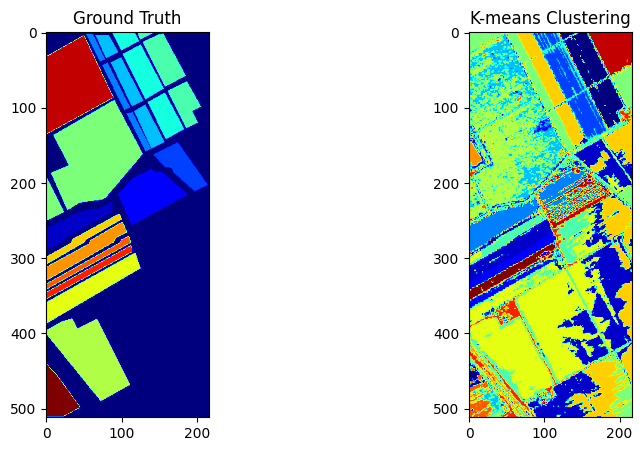

In [108]:
n_clusters = len(np.unique(ground_truth))  # Number of clusters (excluding background)
print(f'Number of clusters: {n_clusters}')
kmeans = KMeans(n_clusters=n_clusters, max_iter=10000)
clusters = kmeans.fit_predict(data_pca)

# Reshape clusters to original image shape
clusters_image = clusters.reshape((n_rows, n_cols))

# Plot the clustering results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(1, 2, 2)
plt.title('K-means Clustering')
plt.imshow(clusters_image, cmap='jet')
plt.show()

# Compare clustering results with ground truth
ground_truth_flat = ground_truth.flatten()
clusters_flat = clusters
mask = ground_truth_flat >-1 # Exclude background
accuracy = accuracy_score(ground_truth_flat[mask], clusters_flat[mask])


In [109]:
clusters

array([8, 8, 8, ..., 8, 8, 8], dtype=int32)

In [110]:
# write Kmeans algorithm by hand just with numpy
import numpy as np

def Kmeans(features, n_clusters, max_iter=100):
    """
    Fits a K-means clustering model to the features.

    Parameters:
        features (np.array): Array of feature values.
        n_clusters (int): Number of clusters to form.
        max_iter (int): Maximum number of iterations.

    Returns:
        np.array: Cluster labels for each data point.
    """
    # Initialize the centroids
    centroids = features[np.random.choice(range(features.shape[0]), n_clusters, replace=False)]
    all_centroids = [centroids]
    all_labels = []
    for _ in range(max_iter):
        # Calculate the distance between each data point and the centroids
        distances = np.array([np.linalg.norm(features - centroid, axis=1) for centroid in centroids])
        # Assign each data point to the closest centroid
        labels = np.argmin(distances, axis=0)
        # Update the centroids
        new_centroids = np.array([features[labels == i].mean(axis=0) for i in range(n_clusters)])

        all_centroids.append(new_centroids)
        all_labels.append(labels)
        # Check if the centroids have converged
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

Number of clusters: 17


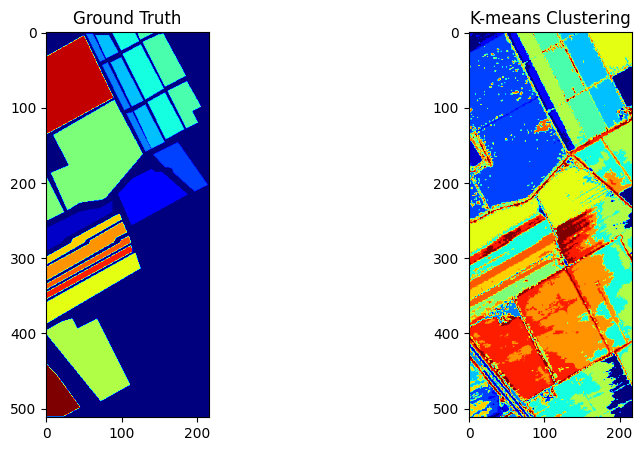

In [111]:
n_clusters = len(np.unique(ground_truth))  # Number of clusters (excluding background)
print(f'Number of clusters: {n_clusters}')
#kmeans = KMeans(n_clusters=n_clusters, max_iter=10000)

clusters, _ = Kmeans(data_pca, n_clusters=n_clusters, max_iter=10000)

# Reshape clusters to original image shape
clusters_image = clusters.reshape((n_rows, n_cols))

# Plot the clustering results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(1, 2, 2)
plt.title('K-means Clustering')
plt.imshow(clusters_image, cmap='jet')
plt.show()

# Compare clustering results with ground truth
ground_truth_flat = ground_truth.flatten()
clusters_flat = clusters
mask = ground_truth_flat >-1 # Exclude background
accuracy = accuracy_score(ground_truth_flat[mask], clusters_flat[mask])


## Try do with libraries

Number of clusters: 17


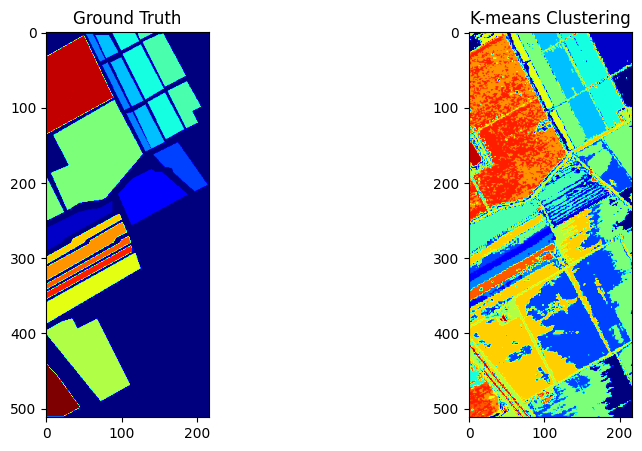

Clustering accuracy: 0.06


In [112]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import scipy.io

# Load the hyperspectral image and ground truth data
data = scipy.io.loadmat('Salinas.mat')['salinas']
ground_truth = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']

# Reshape the data to 2D array (pixels x bands)
n_rows, n_cols, n_bands = data.shape
data_reshaped = data.reshape((n_rows * n_cols, n_bands))

# Apply PCA to reduce dimensions
n_components = 10  # Number of principal components
pca = PCA(n_components=n_components)
data_pca_1 = pca.fit_transform(data_reshaped)
# Perform k-means clustering
n_clusters = len(np.unique(ground_truth))  # Number of clusters (excluding background)
print(f'Number of clusters: {n_clusters}')
kmeans = KMeans(n_clusters=n_clusters, max_iter=10000)
clusters = kmeans.fit_predict(data_pca_1)

# Reshape clusters to original image shape
clusters_image = clusters.reshape((n_rows, n_cols))

# Plot the clustering results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(1, 2, 2)
plt.title('K-means Clustering')
plt.imshow(clusters_image, cmap='jet')
plt.show()

# Compare clustering results with ground truth
ground_truth_flat = ground_truth.flatten()
clusters_flat = clusters
mask = ground_truth_flat > -1 # Exclude background
accuracy = accuracy_score(ground_truth_flat[mask], clusters_flat[mask])
print(f'Clustering accuracy: {accuracy:.2f}')

In [113]:
data_pca_1

array([[-6.13637278e+03, -4.38571386e+03,  6.28407429e+02, ...,
        -2.78342925e+01, -3.16408008e+01, -6.90574669e+01],
       [-6.19694917e+03, -4.36064584e+03,  5.68280593e+02, ...,
        -4.82489985e+01, -5.66423058e+01, -6.47182735e+01],
       [-6.35950363e+03, -4.69393958e+03,  5.78031043e+02, ...,
        -2.27414265e+01, -2.69216085e+01, -6.81051574e+01],
       ...,
       [-6.74048686e+03, -4.12719798e+03,  5.95007971e+02, ...,
         2.65487647e+01, -1.12521817e+00, -2.38392585e+01],
       [-6.76352778e+03, -4.13519799e+03,  5.79182355e+02, ...,
        -6.52548546e+00,  1.82713938e+01, -1.48355183e+01],
       [-6.66408486e+03, -4.01792051e+03,  5.83419721e+02, ...,
         2.72853664e+01,  2.77516176e+01, -1.64949823e+00]])